In [0]:
from __future__ import absolute_import, division, print_function

import argparse
import collections
import hashlib
import math
import os
import random
import sys
from tempfile import gettempdir
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange

import tensorflow as tf

from tensorflow.contrib.tensorboard.plugins import projector

In [0]:
data_index = 0

In [0]:
def _hash_file(fpath):
    hasher = hashlib.sha256()
    with open(fpath, 'rb') as fpath_file:
        for chunk in iter(lambda: fpath_file.read(65535), b''):
            hasher.update(chunk)
    return hasher.hexdigest()

In [0]:
log_dir = './log'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)


In [0]:
url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes, sha256=None):
    """Download a file if not present, and make sure it's the right size."""
    local_filename = os.path.join(gettempdir(), filename)
    if not os.path.exists(local_filename):
        local_filename, _ = urllib.request.urlretrieve(url + filename,
                                                       local_filename)
    statinfo = os.stat(local_filename)

    if sha256 and _hash_file(local_filename) != sha256:
        raise Exception('Failed to verify ' + local_filename + ' due to hash '
                                                               'mismatch. Can you get to it with a browser?')

    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + local_filename +
                        '. Can you get to it with a browser?')
    return local_filename

In [7]:
filename = maybe_download(
    'text8.zip',
    31344016,
    sha256='a6640522afe85d1963ad56c05b0ede0a0c000dddc9671758a6cc09b7a38e5232')

Found and verified text8.zip


In [0]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

In [9]:
vocabulary = read_data(filename)
print('Data size', len(vocabulary))


Data size 17005207


In [0]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000

In [0]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = {}
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = []
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


In [0]:
data, count, unused_dictionary, reverse_dictionary = build_dataset(
    vocabulary, vocabulary_size)

In [14]:
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [0]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels


In [16]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
          reverse_dictionary[labels[i, 0]])

3081 originated -> 5234 anarchism
3081 originated -> 12 as
12 as -> 3081 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 2 of
195 term -> 6 a


In [0]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

In [0]:
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [19]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        with tf.name_scope('embeddings'):
            embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        with tf.name_scope('weights'):
            nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                    stddev=1.0 / math.sqrt(embedding_size)))
        with tf.name_scope('biases'):
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    # Explanation of the meaning of NCE loss and why choosing NCE over tf.nn.sampled_softmax_loss:
    #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
    #   http://papers.nips.cc/paper/5165-learning-word-embeddings-efficiently-with-noise-contrastive-estimation.pdf
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=train_labels,
                inputs=embed,
                num_sampled=num_sampled,
                num_classes=vocabulary_size))

    # Add the loss value as a scalar to summary.
    tf.summary.scalar('loss', loss)

    # Construct the SGD optimizer using a learning rate of 1.0.
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all
    # embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                              valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Merge all summaries.
    merged = tf.summary.merge_all()

    # Add variable initializer.
    init = tf.global_variables_initializer()

    # Create a saver.
    saver = tf.train.Saver()


W0828 06:36:07.454317 140539406620544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
num_steps = 100001

In [22]:
with tf.compat.v1.Session(graph=graph) as session:
    # Open a writer to write summaries.
    writer = tf.summary.FileWriter(log_dir, session.graph)

    # We must initialize all variables before we use them.
    init.run()
    print('Initialized')

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                    skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # Define metadata variable.
        run_metadata = tf.RunMetadata()

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        # Also, evaluate the merged op to get all summaries from the returned
        # "summary" variable. Feed metadata variable to session for visualizing
        # the graph in TensorBoard.
        _, summary, loss_val = session.run([optimizer, merged, loss],
                                           feed_dict=feed_dict,
                                           run_metadata=run_metadata)
        average_loss += loss_val

        # Add returned summaries to writer in each step.
        writer.add_summary(summary, step)
        # Add metadata to visualize the graph for the last run.
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000
            # batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

    # Write corresponding labels for the embeddings.
    with open(log_dir + '/metadata.tsv', 'w') as f:
        for i in xrange(vocabulary_size):
            f.write(reverse_dictionary[i] + '\n')

    # Save the model for checkpoints.
    saver.save(session, os.path.join(log_dir, 'model.ckpt'))

    # Create a configuration for visualizing embeddings with the labels in
    # TensorBoard.
    config = projector.ProjectorConfig()
    embedding_conf = config.embeddings.add()
    embedding_conf.tensor_name = embeddings.name
    embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
    projector.visualize_embeddings(writer, config)

writer.close()


Initialized
Average loss at step  0 :  283.2658386230469
Nearest to people: clu, lichfield, decimated, tj, squaw, orchestral, love, adapting,
Nearest to has: thrives, unpleasant, jn, biologically, metaphysics, aetius, defects, richthofen,
Nearest to united: hinge, disabling, malls, renga, fiji, streams, rembrandt, rumoured,
Nearest to new: randell, rime, polyhedral, mikhailovich, latinized, waterman, consistory, almonds,
Nearest to see: weil, strive, sahelian, repackaged, splitflag, diverged, boarder, archaeopteryx,
Nearest to of: alen, eamon, lumped, elaborates, lut, confuse, flush, foreshadowed,
Nearest to time: walk, legitimately, skinny, declination, ales, starship, sakai, righteous,
Nearest to called: gambler, jinn, mq, governor, tiki, kafka, unsolicited, allude,
Nearest to a: concubines, stubbs, duchamp, plentiful, pollute, alcoholics, legged, leland,
Nearest to other: clocked, lj, ordeal, notice, romanov, federalist, versatile, harpsichord,
Nearest to six: hg, pigmented, calcula

In [0]:
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)

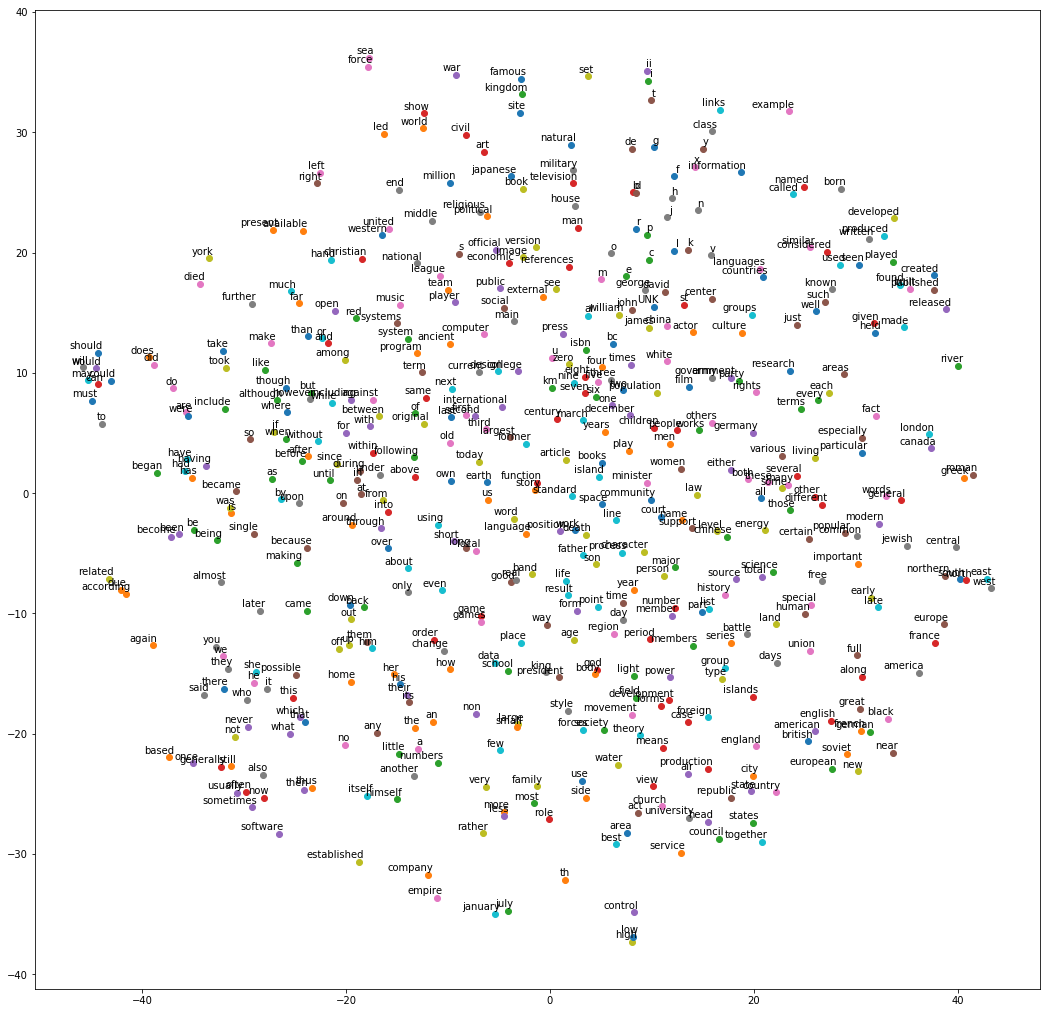

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(),
                                                    'tsne.png'))